# Описание проекта.

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.    
Компания предоставила данные с характеристиками сотрудников компании, одна из которых уровень удовлетворённости сотрудника работой в компании. Собирать данные опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

# Цель проекта

Необходимо будет решить две задачи: первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, так как удовлетворённость работой напрямую влияет на отток сотрудников; второя - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# План работы

Первая задача - предсказание уровня удовлетворённости сотрудника:    
- загрузка и предобработка данных;    
- исследовательский анализ данных;
- подготовка данных;
- обучение моделей;
- вывод;    

Вторая задача - предсказание увольнения сотрудника из компании:    
- загрузка и предобработка данных;    
- исследовательский анализ данных;
- добавление нового входного признака;
- подготовка данных;
- обучение модели;
- вывод;    

Общий вывод

# Описание данных

Данные с признаками:    
 - id — уникальный идентификатор сотрудника;    
 - dept — отдел, в котором работает сотрудник;    
 - level — уровень занимаемой должности;    
 - workload — уровень загруженности сотрудника;    
 - employment_years — длительность работы в компании (в годах);    
 - last_year_promo — показывает, было ли повышение за последний год;    
 - last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;    
 - supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;    
 - salary — ежемесячная зарплата сотрудника;    
 - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.    
 

Тренировочная выборка: train_job_satisfaction_rate.csv    
Входные признаки тестовой выборки: test_features.csv    
Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

In [1]:
!pip install phik -q
!pip install shap==0.44.0  -q
!pip install scikit-learn==1.3.2 -q

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
def infohead(df):
    display(df.head())
    df.info()

In [5]:
def dataset_isdub_isnull(dataset):
    print('Количество явных дубликатов в датасете:', dataset.duplicated().sum())
    print('Количество пропусков в датасете:')
    print(dataset.isnull().sum())

# 1. Первая задача - предсказание уровня удовлетворённости сотрудника

## .1 Загрузка и предобработка данных.

In [6]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [7]:
infohead(train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
dataset_isdub_isnull(train)

Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [9]:
# удалим дубликаты
train = train.drop_duplicates()
train.shape

(4000, 10)

In [10]:
train.loc[train['dept'].isna()].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88


In [11]:
train.loc[train['level'].isna()].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


Проверим категориальные признаки на наличие одинаковых значений или ошибок.

In [12]:
cat_name = ['dept','level','workload','last_year_promo', 'last_year_violations']

for col in cat_name:
    print(col, train[col].unique())

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Зададим индексы столбцом id.

In [13]:
train.set_index('id', inplace=True)
train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [14]:
infohead(X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [15]:
dataset_isdub_isnull(X_test)

Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [16]:
X_test.loc[X_test['dept'].isna()].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [17]:
X_test.loc[X_test['level'].isna()].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [18]:
for col in cat_name:
    print(col, X_test[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [19]:
X_test.loc[X_test['dept'] == ' ', 'dept'] = np.nan
X_test.loc[X_test['workload'] == ' ', 'workload'] = np.nan

In [20]:
for col in cat_name:
    print(col, X_test[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' nan]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [21]:
X_test.set_index('id', inplace=True)
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [22]:
infohead(y_test)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [23]:
y_test.duplicated('id').sum()

0

In [24]:
y_test.set_index('id', inplace=True)
y_test.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


**Вывод:** на данном этапе были изучены датафреймы, проверены на пропуски, явные/неявные дубликаты.
В тренировочной выборке (test) обнаружены пропуски в признаке dept (6) и признаке level (4); обнаружены и удалены дубликаты. В входных признаках тестовой выборки (X_test) обнаружены пропуски в признаке dept (2), признаке level (1) и признаке workload (1) ; обнаружены дубликаты; пробелы в признаках dept и workload были приведины к np.nan, их обработкой займёмся позже.    
Пропуски в тренировочной выборке заполним позже, при обучении модели в пайплайне. Дубликаты в входных признаках тестовой выборки удалять не будем, так как на качество обучения модели они не повлияют. 


# 1.2 Исследовательский анализ данных.

Посмотрим на распределение признаков в тренировочной выборке.

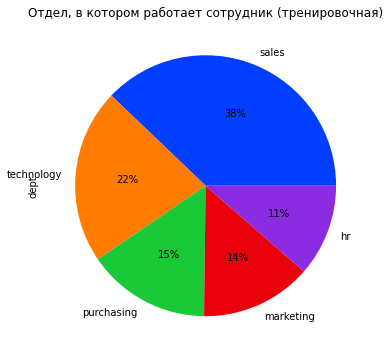

In [25]:
palette_color = sns.color_palette('bright') 
train['dept'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Отдел, в котором работает сотрудник (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

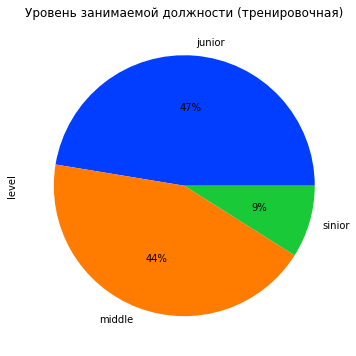

In [26]:
palette_color = sns.color_palette('bright')
train['level'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень занимаемой должности (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

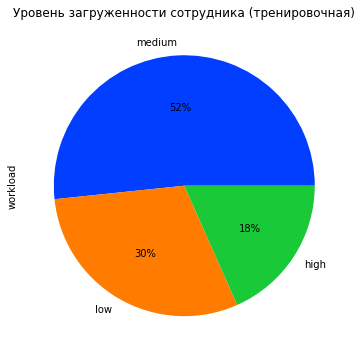

In [27]:
palette_color = sns.color_palette('bright')
train['workload'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень загруженности сотрудника (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

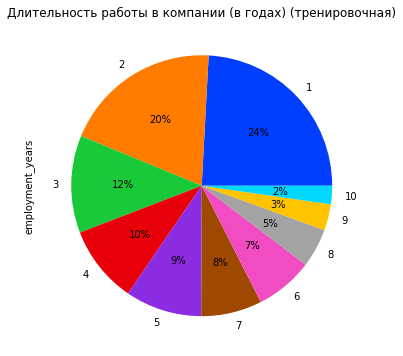

In [28]:
palette_color = sns.color_palette('bright')
train['employment_years'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Длительность работы в компании (в годах) (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

In [29]:
train[train['employment_years'] <= 2]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
693419,hr,junior,medium,1,no,no,3,22800,0.20
198846,hr,junior,low,1,no,no,2,13200,0.14
...,...,...,...,...,...,...,...,...,...
895642,purchasing,junior,medium,2,no,no,2,25200,0.47
855240,sales,junior,medium,2,no,no,3,20400,0.27
457950,technology,junior,high,2,no,no,3,46800,0.45


Возможно, после двух лет отработанных в компании, сотрудники менее удовлетворенны работой, но нет, присутствуют как низникие показатели удовлетворенности так и высокие.

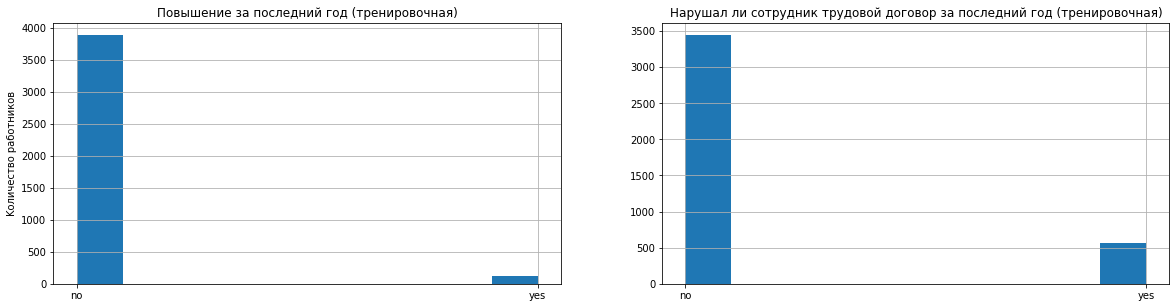

In [30]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

train['last_year_promo'].hist(bins=10,ax=axs[0])
axs[0].set_title('Повышение за последний год (тренировочная)')
axs[0].set_ylabel('Kоличество работников')

train['last_year_violations'].hist(bins=10,ax=axs[1])
axs[1].set_title('Нарушал ли сотрудник трудовой договор за последний год (тренировочная)')


plt.subplots_adjust(top= 0.85 )
plt.show()

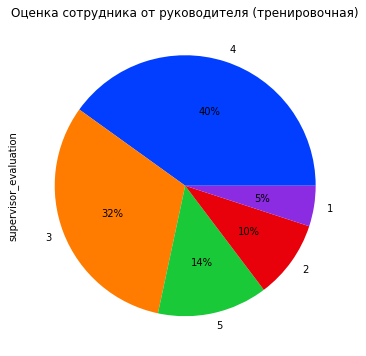

In [31]:
palette_color = sns.color_palette('bright') 
train['supervisor_evaluation'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', \
                                                   title = 'Оценка сотрудника от руководителя (тренировочная)', \
                                                   colors = palette_color, figsize = (14, 6))
plt.show()

In [32]:
train[train['supervisor_evaluation'] <= 2]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
198846,hr,junior,low,1,no,no,2,13200,0.14
381081,marketing,junior,high,2,no,no,2,40800,0.57
...,...,...,...,...,...,...,...,...,...
134106,hr,middle,high,10,no,yes,1,57600,0.39
713279,sales,junior,low,1,no,yes,2,12000,0.09
806663,sales,middle,low,8,no,no,1,22800,0.39


In [33]:
train[['salary', 'job_satisfaction_rate']].describe()

,salary,job_satisfaction_rate
count,4000.000000,4000.000000
mean,33926.700000,0.533995
std,14900.703838,0.225327
min,12000.000000,0.030000
25%,22800.000000,0.360000
50%,30000.000000,0.560000
75%,43200.000000,0.710000
max,98400.000000,1.000000


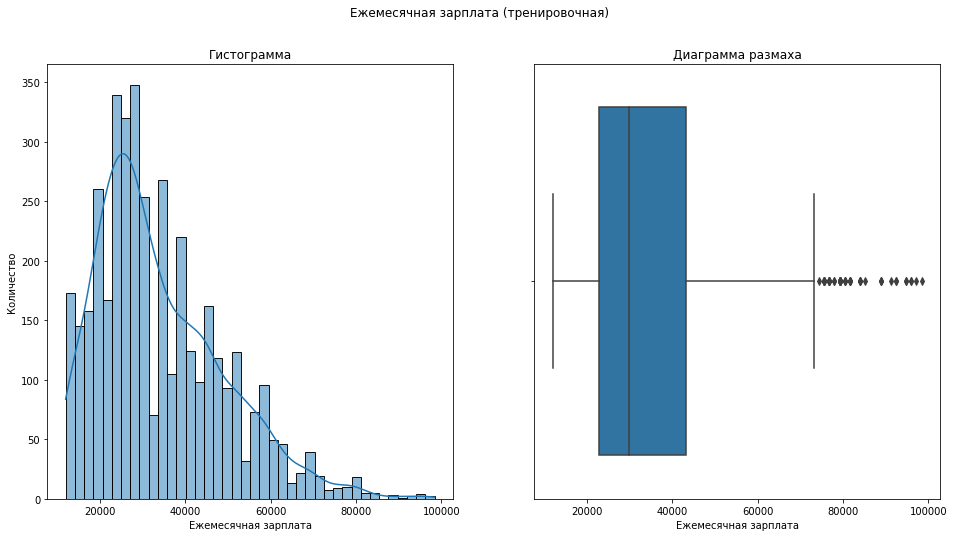

In [34]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = train,x = 'salary', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Ежемесячная зарплата')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = train,x = 'salary', ax=axs[1])
axs[1].set_xlabel('Ежемесячная зарплата')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Ежемесячная зарплата (тренировочная)')
plt.show()

In [35]:
train[train['salary'] > 73000]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
538347,technology,sinior,high,3,no,no,1,84000,0.21
128304,marketing,sinior,high,7,no,no,3,80400,0.48
486576,marketing,sinior,high,9,no,no,4,76800,0.66
405345,marketing,sinior,high,7,no,no,2,81600,0.58
399126,sales,sinior,high,2,no,no,2,76800,0.26
...,...,...,...,...,...,...,...,...,...
214696,sales,sinior,high,5,no,yes,3,75600,0.13
868744,technology,sinior,high,5,yes,no,4,97200,0.84
459612,technology,sinior,high,9,no,no,4,88800,0.79


Высокая ежемесячная зарплата сотрудника, по сравнению с другими сотрудниками, не всегда приносит удовлетворенность работай.

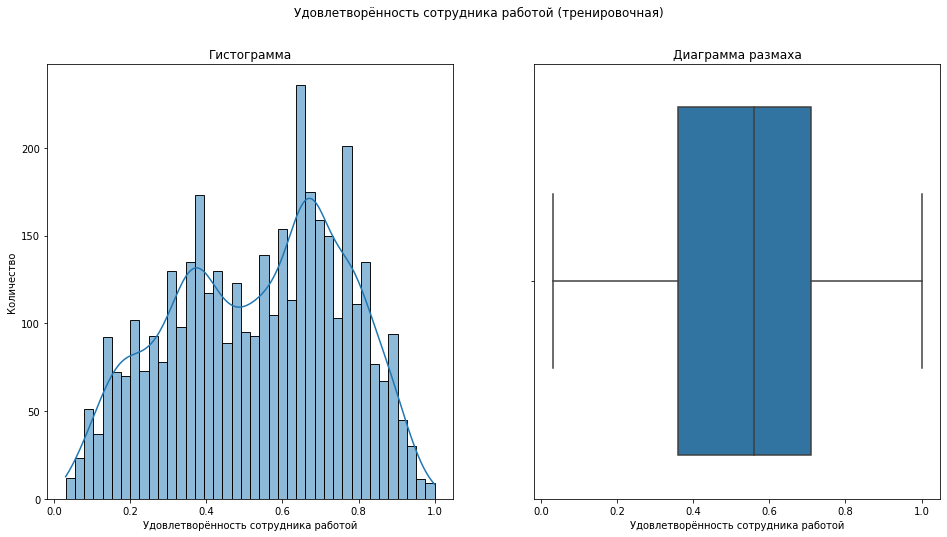

In [36]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = train,x = 'job_satisfaction_rate', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Удовлетворённость сотрудника работой')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = train,x = 'job_satisfaction_rate', ax=axs[1])
axs[1].set_xlabel('Удовлетворённость сотрудника работой')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Удовлетворённость сотрудника работой (тренировочная)')
plt.show()

In [37]:
train.phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


**Вывод:**
- основная часть работников представлена отделом sales (38%), далее идут technology (22%), по 15% и 14% приходятся на purchasing и marketing, замыкает список hr с 11%;
- по уровню занимаемой должности процентное соотношение выглядит следующим образом: junior - 47%, middle - 44%, sinior - 9%;
- по уровню загруженности, основная часть сотрудников medium - 52%, low - 30%, high - 18%;
- большая часть сотрудников проработала в компании 1г - 24% и 2 года - 20%, сотрудников проработавших в компании 8 и более лет меньше всего: 8 лет- 5%, 9 года - 3%, 10 лет - 2%. Можно сделать предположение, что после 2 лет отработанных в компании, сотрудники задумываются об уходе, так как с увелечением продолжительности времени работы в компании, уменьшается количество сотрудников (3 года - 12%, 4 года - 10%, 5 лет - 9%, 6 лет - 7%, 7 лет - 8%);
- большая часть сотрудников повышения за последний год не получали, а нарушение трудового договора замечено у 1/7 части сотрудников; 
- оценку 4 от руководителя получили 40% сотрудников, 3 у 32% сотрудников, 5 у 14%, 2 у 10% и 1 у 5%;
- ежемесячная зарплата в среднем равняется 33900, максимальная 98400, минимальная 12000, медиана 30000; 
- по уровню удовлетворённости сотрудника работой в компании, средняя оценка 0,53, медиана 0,56, максимальное значение 1, минимальное 0,03;    
- у целевого признака job_satisfaction_rate наблюдается связь с last_year_violations и supervisor_evaluation. Если рассматривать общую взаимосвязь признаков, то она нигде не превышает 0,79.

Теперь взгянем на распределение признаков в тестовой выборке.

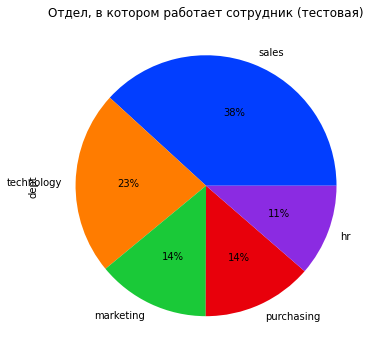

In [38]:
palette_color = sns.color_palette('bright') 
X_test['dept'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Отдел, в котором работает сотрудник (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

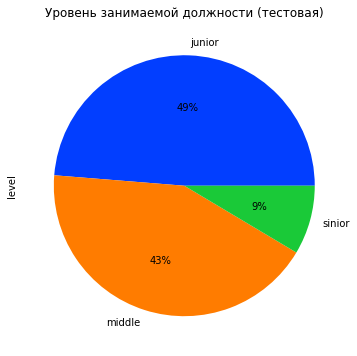

In [39]:
palette_color = sns.color_palette('bright')
X_test['level'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень занимаемой должности (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

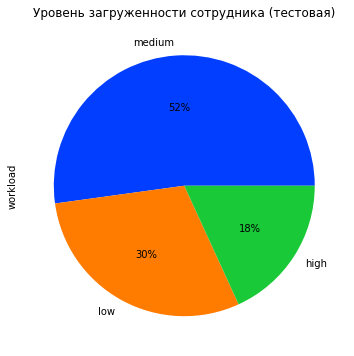

In [40]:
palette_color = sns.color_palette('bright')
X_test['workload'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень загруженности сотрудника (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

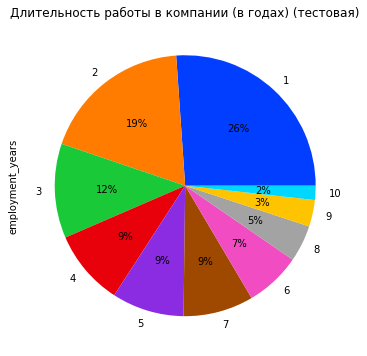

In [41]:
palette_color = sns.color_palette('bright')
X_test['employment_years'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Длительность работы в компании (в годах) (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

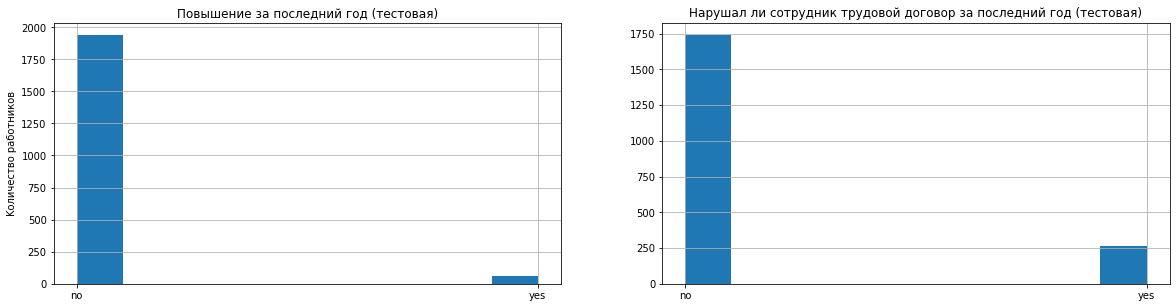

In [42]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

X_test['last_year_promo'].hist(bins=10,ax=axs[0])
axs[0].set_title('Повышение за последний год (тестовая)')
axs[0].set_ylabel('Kоличество работников')

X_test['last_year_violations'].hist(bins=10,ax=axs[1])
axs[1].set_title('Нарушал ли сотрудник трудовой договор за последний год (тестовая)')


plt.subplots_adjust(top= 0.85 )
plt.show()

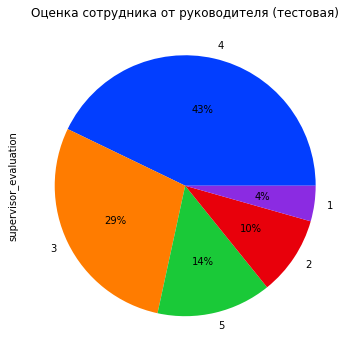

In [43]:
palette_color = sns.color_palette('bright') 
X_test['supervisor_evaluation'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', \
                                                   title = 'Оценка сотрудника от руководителя (тестовая)', \
                                                   colors = palette_color, figsize = (14, 6))
plt.show()

In [44]:
X_test['salary'].describe()

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

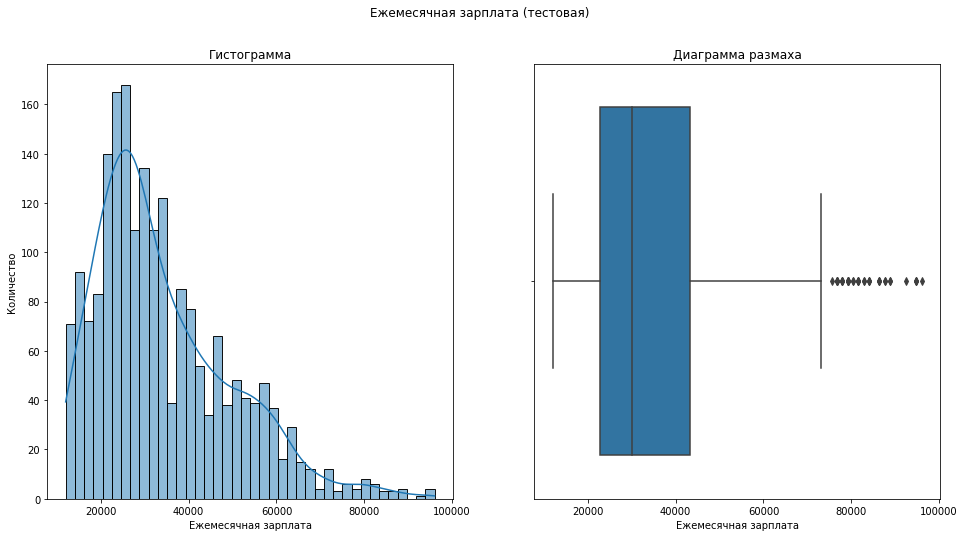

In [45]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = X_test,x = 'salary', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Ежемесячная зарплата')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = X_test,x = 'salary', ax=axs[1])
axs[1].set_xlabel('Ежемесячная зарплата')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Ежемесячная зарплата (тестовая)')
plt.show()

In [46]:
X_test.phik_matrix(interval_cols = ['salary']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
dept,1.000000,0.000000,0.033894,0.000000,0.000000,0.000000,0.060917,0.330406
level,0.000000,1.000000,0.474151,0.689666,0.118258,0.017527,0.000000,0.748998
workload,0.033894,0.474151,1.000000,0.202240,0.035609,0.000000,0.036353,0.785849
employment_years,0.000000,0.689666,0.202240,1.000000,0.173637,0.066371,0.000000,0.494701
last_year_promo,0.000000,0.118258,0.035609,0.173637,1.000000,0.000000,0.011704,0.193727
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000
supervisor_evaluation,0.060917,0.000000,0.036353,0.000000,0.011704,0.189719,1.000000,0.114588
salary,0.330406,0.748998,0.785849,0.494701,0.193727,0.000000,0.114588,1.000000


**Вывод:** сильных отличий с тренировочной выборкой нет

Для подготовки признаков будем использовать:    
- MinMaxScaler/StandartScaler для стобцов employment_years, salary    
- OrdinalEncoder для столбцов supervisor_evaluation, level, workload    
- OneHotEncoder для столбцов dept, last_year_promo, last_year_violations

# 1.3 Подготовка данных.

In [47]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']
X = train.drop(['job_satisfaction_rate'], axis = 1)
y = train['job_satisfaction_rate']

In [48]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse =False)
        )
    ]
)

In [49]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [50]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# 1.4 Обучение моделей.

In [51]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [52]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [Ridge(random_state = RANDOM_STATE)],
        'models__solver': ['saga', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

Выбор лучней модели будем делать на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).

In [53]:
def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

smape_scorer = make_scorer(smape_score, greater_is_better = False)

In [54]:
grid_search = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv = 5,
    scoring=smape_scorer, 
    n_jobs=-1
)
grid_search.fit(X, y)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[...
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [Ridge(random_state=42)],
                          'models__solver': ['saga', 'auto'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape_score, greater_is_better=False))

In [55]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']])),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  ['supervisor_evaluation',
                                                   'employment_years',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(min_samples_split=6, random_state=42))])

In [56]:
print(f'Метрика лучшей модели на кросс-валидации: {-grid_search.best_score_}')

Метрика лучшей модели на кросс-валидации: 14.57123737614124


Лучшей моделью получилось DecisionTreeRegressor(min_samples_split=6, random_state=42). Теперь, проверим её качество на тестовой выборке.

In [57]:
y_test = y_test.sort_index()
X_test = X_test.sort_index()
y_predict = grid_search.predict(X_test)
smape_score(np.array(y_test['job_satisfaction_rate']), y_predict)

13.983212893979857

Значение метрики меньше 15, а значит модель работает успешно.

**Промежуточные выводы:** в данном шаге была найдена и обучена лучшая модель по предсказанию уровня удовлетворённости сотрудника работой. Значение метрики на тестовой выборке составляет 14, что является успехом, ведь для неё необходимо значение меньше 15. Лучшей моделью стала DecisionTreeRegressor (min_samples_split=6, random_state=42). Данная модель справилась лучше линейной регрессии, так как лучше справляется при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что у нас признаков с такой зависимостью много.

# 2. Вторая задача - предсказание уровня удовлетворённости сотрудника

## .1 Загрузка и предобработка данных.

In [58]:
train_2 = pd.read_csv('/datasets/train_quit.csv')
X_test_2 = pd.read_csv('/datasets/test_features.csv')
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')

In [59]:
infohead(train_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [60]:
cat_name_2 = ['dept','level','workload','last_year_promo', 'last_year_violations', 'quit']

for col in cat_name_2:
    print(col, train_2[col].unique())

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


In [61]:
dataset_isdub_isnull(train_2)

Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [62]:
train_2.set_index('id', inplace=True)
train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [63]:
infohead(X_test_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [64]:
dataset_isdub_isnull(X_test_2)

Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [65]:
X_test_2.loc[X_test_2['dept'].isna()].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [66]:
X_test_2.loc[X_test_2['level'].isna()].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [67]:
cat_name_2_test = ['dept','level','workload','last_year_promo', 'last_year_violations']

for col in cat_name_2_test:
    print(col, X_test_2[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [68]:
X_test_2.loc[X_test_2['dept'] == ' ', 'dept'] = np.nan
X_test_2.loc[X_test_2['workload'] == ' ', 'workload'] = np.nan

In [69]:
for col in cat_name_2_test:
    print(col, X_test_2[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' nan]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [70]:
X_test_2.set_index('id', inplace=True)
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [71]:
infohead(y_test_2)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [72]:
dataset_isdub_isnull(y_test_2)

Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id      0
quit    0
dtype: int64


In [73]:
y_test_2['quit'].unique()

array(['yes', 'no'], dtype=object)

In [74]:
y_test_2.set_index('id', inplace=True)
y_test_2.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


**Вывод:** на данном этапе были изучены датафреймы, проверены на пропуски, явные/неявные дубликаты.
В входных признаках тестовой выборки (X_test_2) обнаружены пропуски в признаке dept (2), признаке level (1); пробелы в признаках dept и workload были приведины к np.nan, их обработкой займёмся позже.    
Пропуски заполним позже, при обучении модели в пайплайне.

# 2.2 Исследовательский анализ данных.

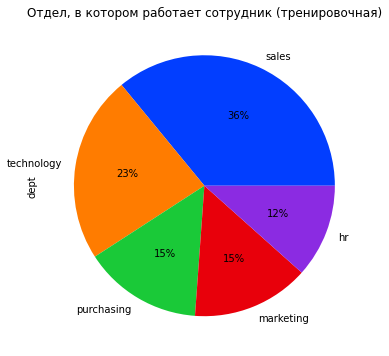

In [75]:
palette_color = sns.color_palette('bright') 
train_2['dept'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Отдел, в котором работает сотрудник (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

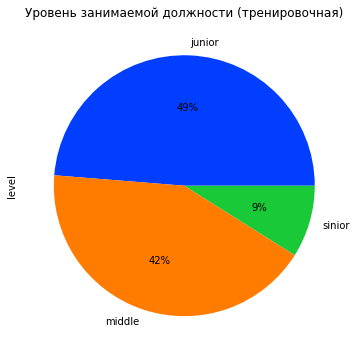

In [76]:
palette_color = sns.color_palette('bright')
train_2['level'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень занимаемой должности (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

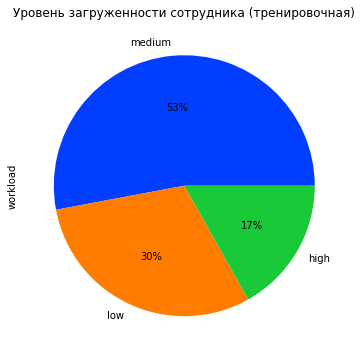

In [77]:
palette_color = sns.color_palette('bright')
train_2['workload'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень загруженности сотрудника (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

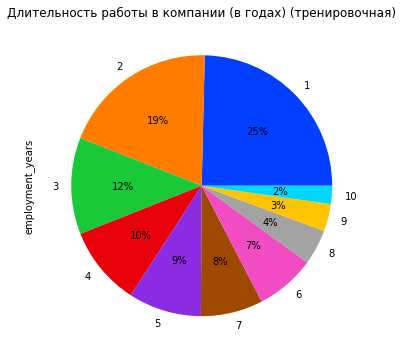

In [78]:
palette_color = sns.color_palette('bright')
train_2['employment_years'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Длительность работы в компании (в годах) (тренировочная)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

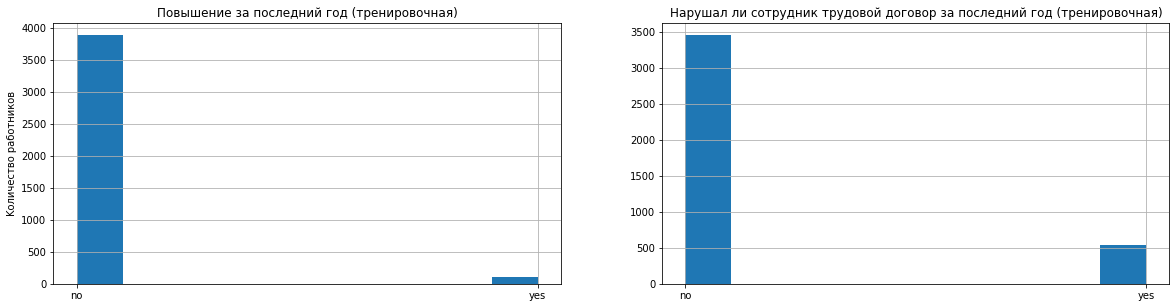

In [79]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

train_2['last_year_promo'].hist(bins=10,ax=axs[0])
axs[0].set_title('Повышение за последний год (тренировочная)')
axs[0].set_ylabel('Kоличество работников')

train_2['last_year_violations'].hist(bins=10,ax=axs[1])
axs[1].set_title('Нарушал ли сотрудник трудовой договор за последний год (тренировочная)')


plt.subplots_adjust(top= 0.85 )
plt.show()

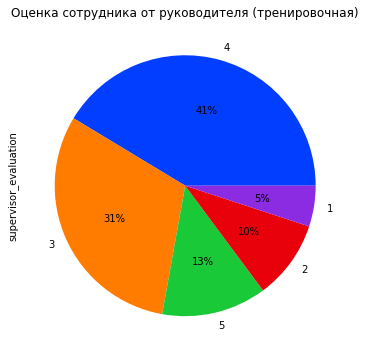

In [80]:
palette_color = sns.color_palette('bright') 
train_2['supervisor_evaluation'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', \
                                                   title = 'Оценка сотрудника от руководителя (тренировочная)', \
                                                   colors = palette_color, figsize = (14, 6))
plt.show()

In [81]:
train_2['salary'].describe()

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

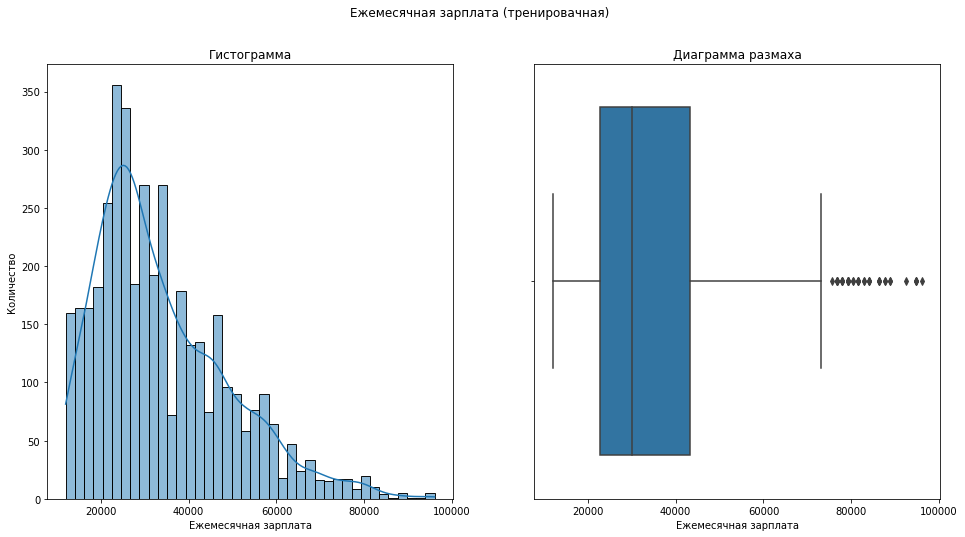

In [82]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = train_2,x = 'salary', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Ежемесячная зарплата')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = X_test,x = 'salary', ax=axs[1])
axs[1].set_xlabel('Ежемесячная зарплата')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Ежемесячная зарплата (тренировачная)')
plt.show()

In [83]:
train_2.phik_matrix(interval_cols = ['salary']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000


Теперь взглянем на распределение признаков в тестовой выборке.

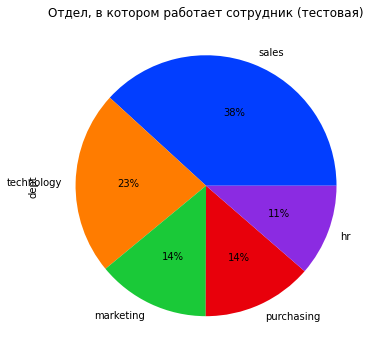

In [84]:
palette_color = sns.color_palette('bright') 
X_test_2['dept'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Отдел, в котором работает сотрудник (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

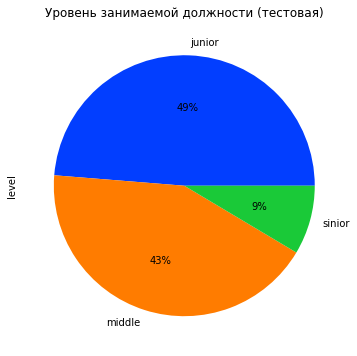

In [85]:
palette_color = sns.color_palette('bright')
X_test_2['level'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень занимаемой должности (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

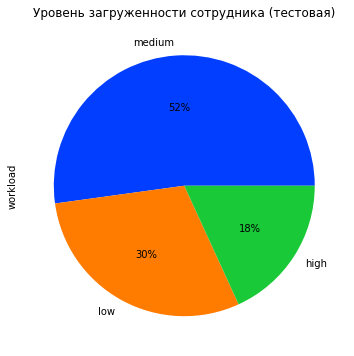

In [86]:
palette_color = sns.color_palette('bright')
X_test_2['workload'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Уровень загруженности сотрудника (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

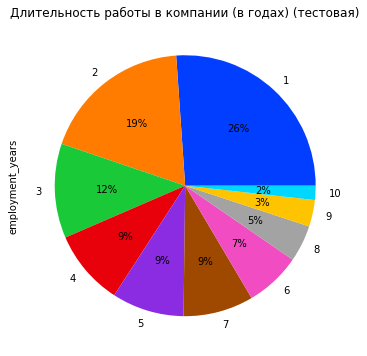

In [87]:
palette_color = sns.color_palette('bright')
X_test_2['employment_years'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%',\
                                  title = 'Длительность работы в компании (в годах) (тестовая)',\
                                  colors = palette_color, figsize = (14, 6))
plt.show()

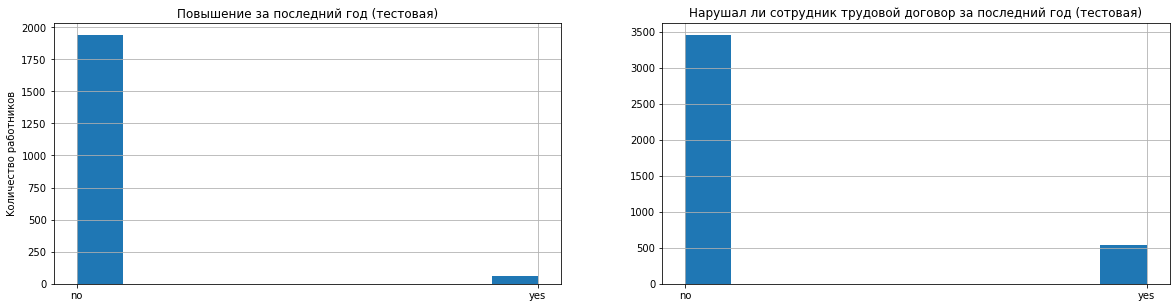

In [88]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

X_test_2['last_year_promo'].hist(bins=10,ax=axs[0])
axs[0].set_title('Повышение за последний год (тестовая)')
axs[0].set_ylabel('Kоличество работников')

train_2['last_year_violations'].hist(bins=10,ax=axs[1])
axs[1].set_title('Нарушал ли сотрудник трудовой договор за последний год (тестовая)')


plt.subplots_adjust(top= 0.85 )
plt.show()

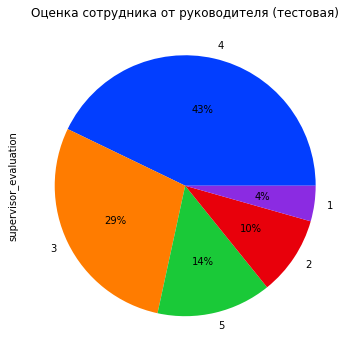

In [89]:
palette_color = sns.color_palette('bright') 
X_test_2['supervisor_evaluation'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', \
                                                   title = 'Оценка сотрудника от руководителя (тестовая)', \
                                                   colors = palette_color, figsize = (14, 6))
plt.show()

In [90]:
X_test_2['salary'].describe()

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

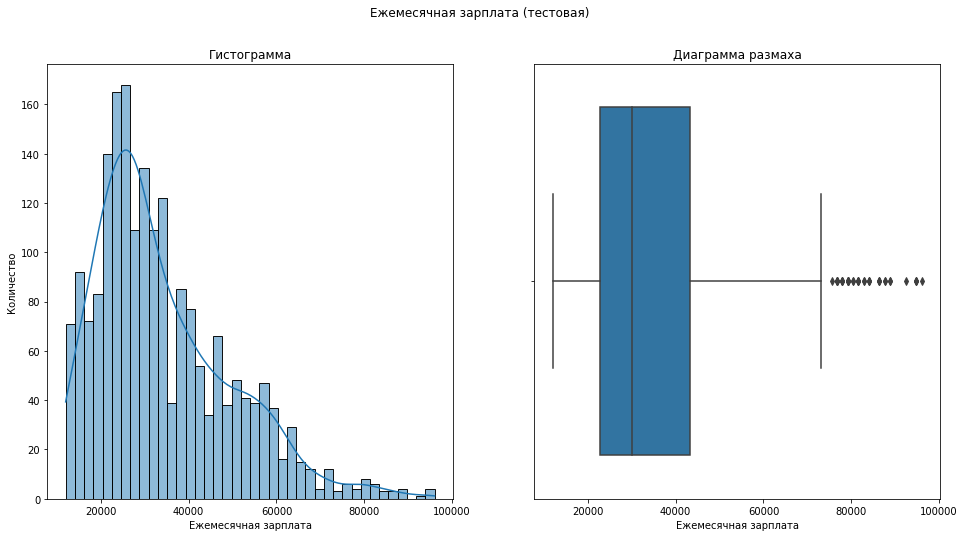

In [91]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = X_test_2,x = 'salary', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Ежемесячная зарплата')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = X_test,x = 'salary', ax=axs[1])
axs[1].set_xlabel('Ежемесячная зарплата')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Ежемесячная зарплата (тестовая)')
plt.show()

In [92]:
X_test_2.phik_matrix(interval_cols = ['salary']).style.background_gradient(cmap ='coolwarm')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
dept,1.000000,0.000000,0.033894,0.000000,0.000000,0.000000,0.060917,0.330406
level,0.000000,1.000000,0.474151,0.689666,0.118258,0.017527,0.000000,0.748998
workload,0.033894,0.474151,1.000000,0.202240,0.035609,0.000000,0.036353,0.785849
employment_years,0.000000,0.689666,0.202240,1.000000,0.173637,0.066371,0.000000,0.494701
last_year_promo,0.000000,0.118258,0.035609,0.173637,1.000000,0.000000,0.011704,0.193727
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000
supervisor_evaluation,0.060917,0.000000,0.036353,0.000000,0.011704,0.189719,1.000000,0.114588
salary,0.330406,0.748998,0.785849,0.494701,0.193727,0.000000,0.114588,1.000000


**Вывод:** больших отличий в данных не заметно, выбросов и аномалий не обнаружено. 

Портрет «уволившегося сотрудника».

Узнаем, в каком отделе с большей вероятностью работает уволившийся сотрудник, какой у него уровень загруженности и какой уровень занимаемой должности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

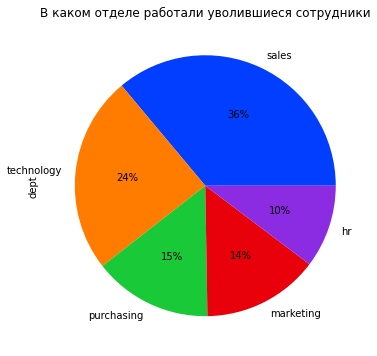

In [93]:
palette_color = sns.color_palette('bright') 
train_2.loc[train_2['quit'] == 'yes', 'dept'].value_counts().\
plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'В каком отделе работали уволившиеся сотрудники',\
     colors = palette_color, figsize = (14, 6))
plt.show()

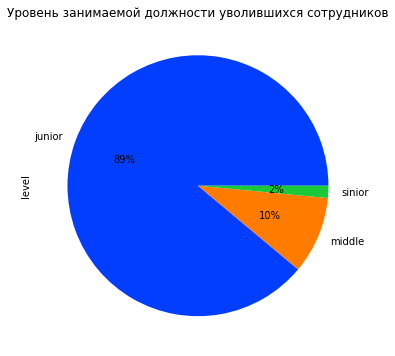

In [94]:
palette_color = sns.color_palette('bright') 
train_2.loc[train_2['quit'] == 'yes', 'level'].value_counts().\
plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень занимаемой должности уволившихся сотрудников',\
     colors = palette_color, figsize = (14, 6))
plt.show()

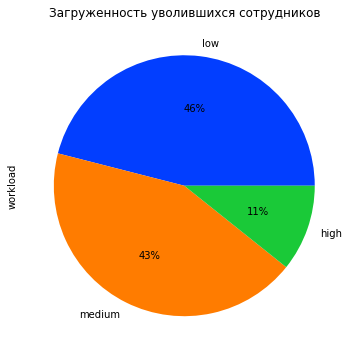

In [95]:
palette_color = sns.color_palette('bright') 
train_2.loc[train_2['quit'] == 'yes', 'workload'].value_counts().\
plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Загруженность уволившихся сотрудников',\
     colors = palette_color, figsize = (14, 6))
plt.show()

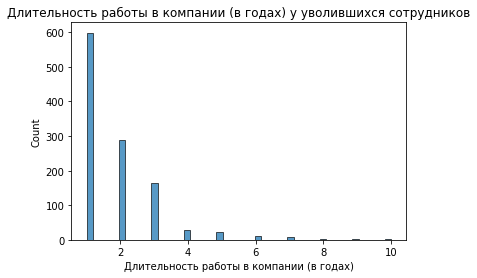

In [96]:
sns.histplot(data = train_2.loc[train_2['quit'] == 'yes'], x='employment_years')
plt.xlabel('Длительность работы в компании (в годах)')
plt.title('Длительность работы в компании (в годах) у уволившихся сотрудников')
plt.show()

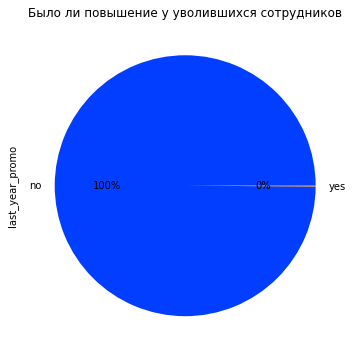

In [97]:
palette_color = sns.color_palette('bright') 
train_2.loc[train_2['quit'] == 'yes', 'last_year_promo'].value_counts().\
plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Было ли повышение у уволившихся сотрудников', \
     colors = palette_color, figsize = (14, 6))
plt.show()

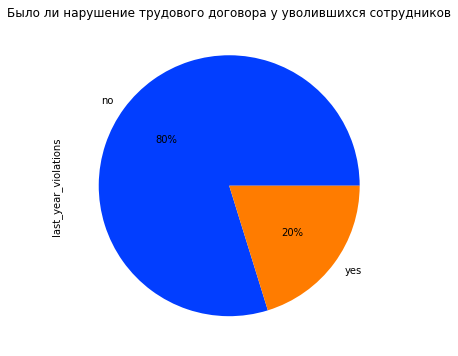

In [98]:
palette_color = sns.color_palette('bright') 
train_2.loc[train_2['quit'] == 'yes', 'last_year_violations'].value_counts().\
plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Было ли нарушение трудового договора у уволившихся сотрудников',\
     colors = palette_color, figsize = (14, 6))
plt.show()

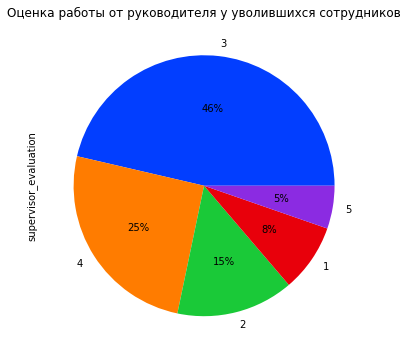

In [99]:
palette_color = sns.color_palette('bright') 
train_2.loc[train_2['quit'] == 'yes', 'supervisor_evaluation'].value_counts().\
plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Оценка работы от руководителя у уволившихся сотрудников',\
     colors = palette_color, figsize = (14, 6))
plt.show()

In [100]:
no = train_2.loc[train_2['quit'] == 'no', 'salary'].mean()
yes = train_2.loc[train_2['quit'] == 'yes', 'salary'].mean()
(no/yes - 1)*100

57.84827502013581

Таким образом, портрет уволившегося сотрудника выглядит следующим образом:    
- отдел, в котором работает сотрудник: sales - 36%, technolog - 24%;    
- уровень занимаемой должности: junior - 89%;    
- уровень загруженности сотрудника: low - 46%, medium - 43%;    
- длительность работы в компании (в годах): как правило меньше 3х лет (большинство и вовсе 1 год);    
- повышений за последний год не было;    
- нарушений трудового договора в основном ни у кого нет (80% против 20%);    
- большинство имеют оценку 3 от руководителя (46%), вторая по популярности - 4 (25%);    
- средняя зааботная плата неуволившегося сотрудника на 58% больше уволившегося.

Визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

In [101]:
y_test_2 = y_test_2.sort_index()
X_test_2 = X_test_2.sort_index()

In [102]:
new_test = X_test_2
new_test['job_satisfaction_rate'] = y_test['job_satisfaction_rate']
new_test['quit'] = y_test_2['quit']
new_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80,no
100480,marketing,junior,low,4,no,no,4,16800,0.84,no
100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
100610,sales,middle,medium,5,no,no,4,43200,0.75,no
100692,sales,middle,high,6,no,no,4,48000,0.69,no


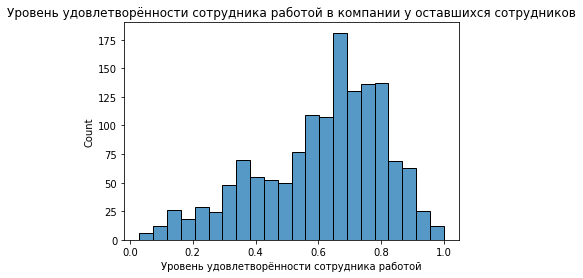

In [103]:
sns.histplot(data = new_test.loc[new_test['quit']=='no'], x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости сотрудника работой в компании у оставшихся сотрудников')
plt.show()

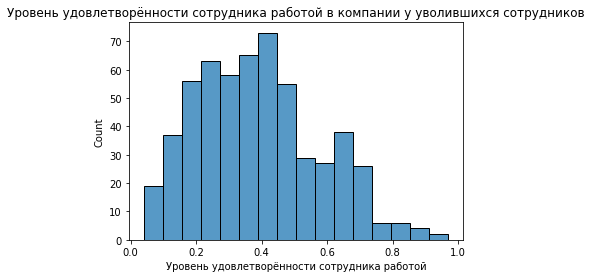

In [104]:
sns.histplot(data = new_test.loc[new_test['quit']=='yes'], x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости сотрудника работой в компании у уволившихся сотрудников')
plt.show()

Анализируя данные графики можно сказать, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, ведь если у уволившихся сотрудниках в большинстве случаев он меньше 0.5, то у оставшихся - больше 0.5

# 2.3 Добавление нового входного признака.

Добавим новый столбец к датафреймам

In [105]:
train_2['job_satisfaction_rate'] = grid_search.predict(train_2.drop(['quit'], axis = 1))
X_test_2['job_satisfaction_rate'] = grid_search.predict(X_test_2)
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.820000,no
100480,marketing,junior,low,4,no,no,4,16800,0.852000,no
100503,purchasing,middle,high,5,no,no,4,55200,0.746667,no
100610,sales,middle,medium,5,no,no,4,43200,0.813333,no
100692,sales,middle,high,6,no,no,4,48000,0.697500,no


# 2.4 Подготовка данных.

In [106]:
he_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']

X = train_2.drop(['quit'], axis = 1)
y = train_2['quit']

# 2.5 Обучение модели.

In [107]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [108]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.

In [109]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X, y)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=...
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [110]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']])),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  ['supervisor_evaluation',
                                                   'employment_years',
                                                   'salary'])])),
                ('models', SVC(C=3, probability=True, random_state=42))])

Лучшей моделью оказался метод опорных векторов SVC(C=3, probability=True, random_state=42)

In [111]:
randomized_search.best_score_

0.9277326864303657

In [112]:
y_predict_proba = randomized_search.predict_proba(X_test_2)
roc_auc_score(y_test_2, y_predict_proba[:, 1])

0.9253979483988225

Значение метрики больше чем 0.91, значит всё прошло успешно

**Выводы:** В данном шаге была найдена и обучена лучшая модель по предсказанию увольнения сотрудника. Значение метрики на тестовой выборке составляет 0.92, что является успехом, ведь для неё необходимо значение >=0.91. Лучшей моделью стал метод опорных векторов SVC(C=3, probability=True, random_state=42). Данная модель справилась лучше остальных, так как больше подходит когда данных немного или целевой признак нелинейно зависит от входных, а, учитывая матрицу корреляции, можно сказать, что у нас признаков с такой зависимостью много.

# Общий вывод.

Перед нами стояло несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.    
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.    

При решении обеих задач были пройдены следующие этапы:

Загрузка и первичное изучение данных
Предобработка данных: данные были проверены на пропуски и дубликаты
Исследовательский анализ данных: построение графиков, матриц корелляции
Подготовка данных: написание пайплайнов для подготовки данных (кодирование, масштабирование)
Обучение модели: был написан пайплайн, который перебирал модели, способы масштабирования и гиперпараметры

Рекомендации бизнессу по снижению уровня увольнений:

Больше всего уволилось сотрудников из отделов sales, technology - следует провести доп. опросы данных отделов
80% из уволившихся - уровень junior, работают от 1 до 3х лет - следует больше времени уделять новичкам
Почти у 100% уволившихся не было повышения за последний год - стоит подумать о карьерном росте сотрудников
Средняя заработная плата неуволившегося сотрудника на 58% больше уволившегося - возможно необходимо стимулировать работников прибавкой к заработной плате или рассмотреть возможность в поощрении работников премиями
Есть зависимость между увольнением и удовлетворённостью сотрудника.    
Используя написанную мною модель, ей оказалась метод опорных векторов SVC(C=3, probability=True, random_state=42), можно предсказывать удовлетворённость сотрудников, и при необходимости проводить дополнительные меры/опросы с целью её увеличения.